# Health Risk Prediction

Fall 2025 Data Science Project

Abhinav Akenapalli, Nathan James, Laila Shakoor, Amy Tan

### Contributions

## Project Idea

## Data Curation and Preprocessing

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestClassifier

In [6]:
df = pd.read_csv("health-risk-prediction-anonymized-real-data/Health_Risk_Dataset.csv")
df.head()

,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB


In [8]:
df.describe()

,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,On_Oxygen
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21.511000,92.59000,1.124000,106.160000,98.460000,37.921000,0.274000
std,5.287517,4.47302,0.329746,17.897562,19.694626,1.113696,0.446232
min,12.000000,74.00000,1.000000,50.000000,60.000000,35.600000,0.000000
25%,17.000000,90.00000,1.000000,94.000000,84.000000,37.100000,0.000000
50%,20.000000,94.00000,1.000000,109.000000,95.500000,37.800000,0.000000
75%,25.000000,96.00000,1.000000,119.000000,109.000000,38.600000,1.000000
max,40.000000,100.00000,2.000000,146.000000,163.000000,41.800000,1.000000


In [17]:
# Pre-processing: Converting PatientID to String; Consciousness, On_Oxygen, and Risk_Level to category
df["Patient_ID"] = df["Patient_ID"].astype("string")
df["O2_Scale"] = df["O2_Scale"].astype("category")
df["Consciousness"] = df["Consciousness"].astype("category")
df["On_Oxygen"] = df["On_Oxygen"].astype("category")
df["Risk_Level"] = df["Risk_Level"].astype("category")
# Dropping any nan values
df = df.dropna(how='any')

## Data Exploration and Summary Statistics

### Z-Test for Outliers

Question: Are there extreme outliers (z-score greater than 3) in the continuous features of our Health Risk Prediction dataset?

In [10]:
continuous_features = ['Respiratory_Rate', 'Oxygen_Saturation', 'Systolic_BP',
            'Heart_Rate', 'Temperature']

for col in continuous_features:
    z = (df[col] - df[col].mean()) / df[col].std()
    df[f'{col}_Z'] = z
    outliers = df[np.abs(z) > 3]
    print(f"\n{col}: {len(outliers)} outliers")


Respiratory_Rate: 2 outliers

Oxygen_Saturation: 8 outliers

Systolic_BP: 2 outliers

Heart_Rate: 4 outliers

Temperature: 6 outliers


#### Visualization

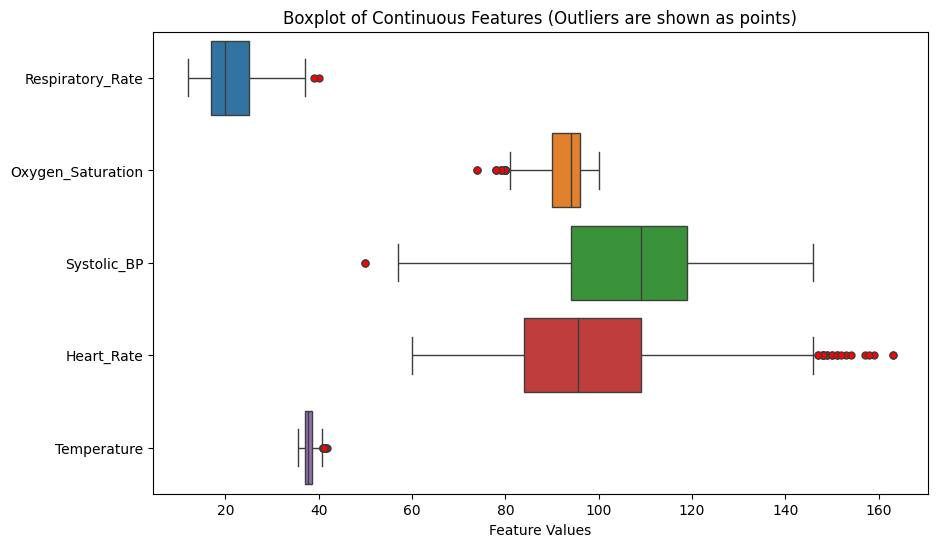

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[continuous_features], orient='h', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
plt.title("Boxplot of Continuous Features (Outliers are shown as points)")
plt.xlabel("Feature Values")
plt.show()

#### Conclusion 1

There are 2-8 outliers (z-score greater than 3) in each continuous column of the dataset.

### T-Test for Oxygen Saturation

**Research Question**: Does being on supplemental oxygen ("On_Oxygen") significantly affect patients' mean oxygen saturation?

**Groups:**
- Group 1 (0): Not on oxygen
- Group 2 (1): On oxygen
  
**Variable**: Oxygen_Saturation

#### Hypotheses

- **Null Hypothesis**: There is no difference in mean oxygen saturation between patients on oxygen vs. those not on oxygen.
- **Alternative Hypothesis**: Being on supplemental oxygen changes the mean oxygen saturation between the two groups.
This is a two-sample, two-tailed t-test.

#### Assumptions

- Independence: Each pateint is unique.
- Normality: With n approximately 1000, CLT supports near-normal mean distribution.

T-statistic = -11.896, p-value = 0.000000000000000000000000000421


<Axes: xlabel='On_Oxygen', ylabel='Oxygen_Saturation'>

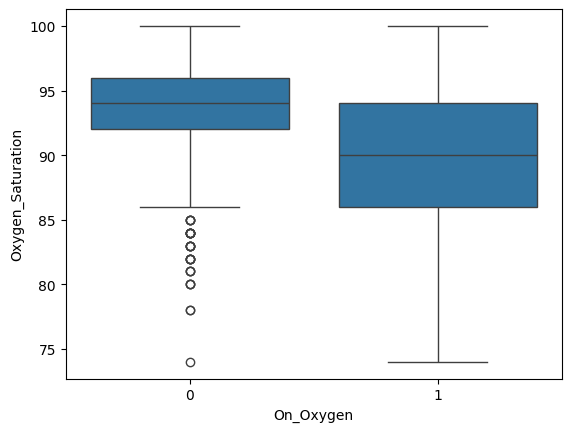

In [12]:
df = pd.read_csv("health-risk-prediction-anonymized-real-data/Health_Risk_Dataset.csv")

group_on = df[df['On_Oxygen'] == 1]['Oxygen_Saturation']
group_off = df[df['On_Oxygen'] == 0]['Oxygen_Saturation']

t_stat, p_val = stats.ttest_ind(group_on, group_off, equal_var=False)

print(f"T-statistic = {t_stat:.3f}, p-value = {p_val:.30f}")

sns.boxplot(x="On_Oxygen", y="Oxygen_Saturation", data=df)

#### Conclusion 2

Since p < 0.005: We reject the Null Hypothesis. Thus, Oxygen therapy is associated with different mean oxygen saturation.

Note: There were multiple outliers found in the non-oxygenated group, with many of them having uncommonly high oxygen saturations pre-oxygen therapy.

### ANOVA Test for Respiratory Rate On Risk Level

**Question**:
Is there a difference in the respiratory rates in each risk category?

**Null Hypothesis**:
There is no difference in respiratory rates between risk categories.

**Alternate Hypothesis**:
There is a statisically significant difference in respiratory rates among risk categories.

In [13]:
groups = df.groupby("Risk_Level")
new_groups = [group["Respiratory_Rate"].values for name, group in groups]
f_stat, p_val = stats.f_oneway(*new_groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_val}")

ANOVA F-statistic: 724.3706495626732, p-value: 9.680624282636591e-250


#### Post-Hoc Analysis

In [14]:
tukey = pairwise_tukeyhsd(endog=df["Respiratory_Rate"], groups=df["Risk_Level"], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
  High    Low  -9.5003   0.0 -10.1621  -8.8384   True
  High Medium   -7.031   0.0  -7.6634  -6.3986   True
  High Normal -12.0804   0.0  -12.838 -11.3228   True
   Low Medium   2.4693   0.0   1.8215    3.117   True
   Low Normal  -2.5801   0.0  -3.3506  -1.8097   True
Medium Normal  -5.0494   0.0  -5.7947  -4.3041   True
-----------------------------------------------------


#### Visualization

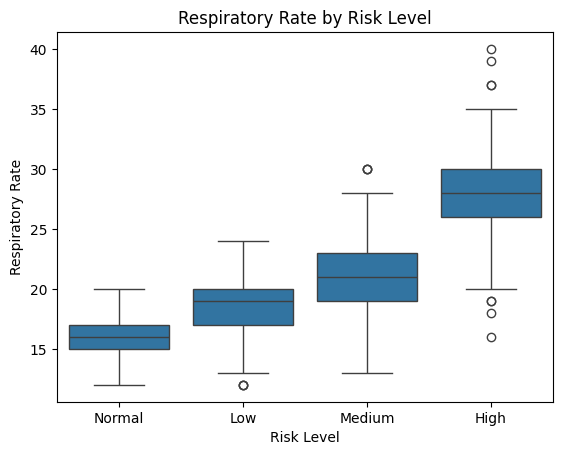

In [15]:
sns.boxplot(x="Risk_Level", y="Respiratory_Rate", data=df, order=["Normal", "Low", "Medium", "High"])
plt.xlabel("Risk Level")
plt.ylabel("Respiratory Rate")
plt.title("Respiratory Rate by Risk Level")
plt.show()

#### Conclusion 3

After running a one-way ANOVA on respiratory rates against risk levels, it was found that at least one mean is statistically different among the groups with a p-value less than 0.05. To further investigate this, a post hoc Tukey's HSD was run and determined a relationship such that respiratory rates increase in the following order: normal, low, medium, high. This indicates that each level increase like low to medium, corresponds with an increase in respiratory rate. The data contains outliers with the low, medium, and high levels. However, the data still trends in the direction that an increase in respiratory rate corresponds with an increase in risk level.

## ML Algorithm Design/Development

#### Feature Engineering 

##### Label Encoding 
We want to convert discrete values to some random number. We can do this with label encoding, which assigns a unique integer to each category.

In [25]:
encoder  = LabelEncoder()
df['Consciousness'] = encoder.fit_transform(df['Consciousness'])

##### Feature Importance Using Random Forest
Some features have a more significant impact on the final prediction than other features do. In order to limit dimensionality, we want to make sure that we're selecting our most influential and useful features. Here, we can use the random forest classifier's feature importance attribute to rank our features by importance. In this case, feature importance is measured by mean decrease in impurity (MDI).

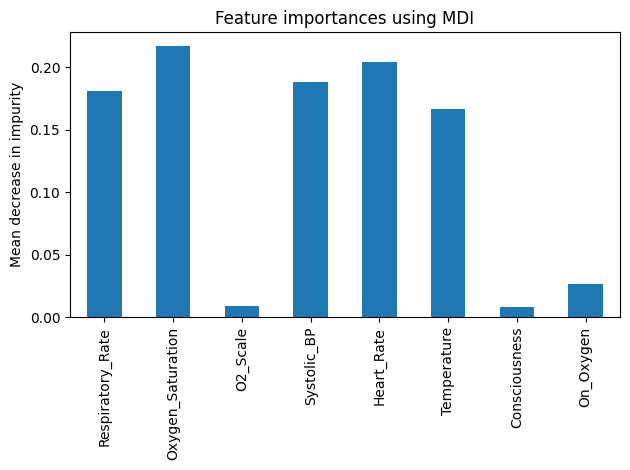

In [30]:
# Dropping Patient ID because it is used for identification purposes only
# Dropping Risk Level because it is what we want to predict 
X = df.drop(columns=["Risk_Level", "Patient_ID"])
y = df["Risk_Level"]

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X, y)

# Extracting feature importances 
importances = model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

# Plotting
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We can see that oxygen saturation, heart rate, systolic bp, respiratory rate, and temperature are our most significant features. However, since we don't have that many features in this particulat dataset, we elected to use all the vital statistics when training our classifier. 

## ML Algorithm Training and Test Data Analysis

## Visualization, Result Analysis, Conclusion